In [144]:
import pandas as pd
import re
import numpy as np
import seaborn as sns

def process_data(data=None, return_gde=False):
  """Processes immoscout_cleaned_lat_lon_fixed_v9.csv according to eda findings and returns a tidy dataset. 

  Args:
      data (DataFrame, optional): Uses immoscout_cleaned_lat_lon_fixed_v9.csv if left default. Defaults to None.
      return_gde (bool, optional): Return with or without extra columns ('ForestDensityL':'gde_workers_total'). Defaults to False.

  Returns:
      DataFrame: tidy DataFrame
  """
  def parse_floor(x):
    if x != x:
      return np.nan
    elif x == 'Ground floor':
      return 0
    elif re.search('\. floor', x):
      return re.search('\d+', x).group()
    elif re.search('Basement', x):
      return '-' + re.search('\d+', x).group()
    
  def parse_street(x):
    if len(x) > 0:
      m = re.search(r"\d", x)
      if m:
        return x[0:m.start()-1]
      else:
        return x
    else:
      return np.NaN

  col_names = data.columns.array
  col_names[0:2] = ['Index1', 'Index2']
  data.columns = col_names

  data_cleaned = pd.DataFrame() 

  # Merge columns
  ## Living Space
  data['living_space'] = data['Space extracted']
  # data['details_ls'] = data['details'].str.extract(', (\d+) m').astype(float)
  # data.loc[data['details_ls'].notna() & data['living_space'].isna(), 'living_space'] = data.loc[data['details_ls'].notna() & data['living_space'].isna(), 'details_ls']
  data_cleaned['living_space'] = data['living_space'].astype(float)

  ## Rooms
  data_cleaned['rooms'] = data['details'].str.extract('(\d+\.?\d?) rooms, ').astype(float)

  ## Plot Area
  data_cleaned['plot_area'] = data['Plot_area_merged'].fillna('') + \
    data['detail_responsive#surface_property'].fillna('')

  ## Floor Space
  data_cleaned['floor_space'] = data['Floor_space_merged'].fillna('') + \
    data['detail_responsive#surface_usable'].fillna('')

  ## FLoor
  data_cleaned['floor'] = data['Floor_merged'].fillna('') + \
    data['detail_responsive#floor'].fillna('')

  ## Availability
  data_cleaned['availability'] = data['Availability_merged'].fillna('') + \
    data['detail_responsive#available_from'].fillna('')

  ## Price
  data_cleaned['price'] = data['price_cleaned']

  ## Municipality
  data_cleaned['municipality'] = data['Locality']

  ## Street
  data_cleaned["street"] = data['address'].str.extract(r'^([A-Z].+?), ')
  data_cleaned["street_nr"] = data_cleaned['street'].str.extract(r'^.+ (\d.+)')
  data_cleaned["street"] = data_cleaned['street'].fillna('').apply(parse_street)
  data_cleaned["street"] = data_cleaned['street'].str.rstrip()
  data_cleaned[data_cleaned["street"] == 'Lausanne'] = np.NaN
  data_cleaned[data_cleaned["street"] == 'Lugano'] = np.NaN

  ## Zip Code
  data_cleaned['zip_code'] = data['address'].str.extract(r'(\d{4})')
  data_cleaned['zip_code'] = pd.Categorical(data_cleaned['zip_code'])

  ## Canton
  data_cleaned['canton'] = data['address'].str.extract(r'(\w{2})$')
  data_cleaned['canton'] = pd.Categorical(data_cleaned['canton'])

  ## url
  data_cleaned['url'] = data['url']

  # Parsing
  data_cleaned['plot_area'] = data_cleaned['plot_area'].replace('', np.nan).str.extract('(\d+,?\d*)')
  data_cleaned['plot_area'] = data_cleaned['plot_area'].str.replace(',', '').astype(float)
  data_cleaned['floor_space'] = data_cleaned['floor_space'].replace('', np.nan).str.extract('(\d+,?\d*)')
  data_cleaned['floor_space'] = data_cleaned['floor_space'].str.replace(',', '').astype(float)
  data_cleaned['floor'] = data_cleaned['floor'].replace('', np.nan).apply(parse_floor).astype(float)
  data_cleaned['availability'] = data_cleaned['availability'].replace('', np.nan)

  # Merge DataFrames
  data_cleaned = data_cleaned.join(data.loc[:, 'ForestDensityL':'type'])
  data_cleaned.drop(['price_cleaned', 'Locality'], axis=1, inplace=True)

  # Drop duplicates
  data_cleaned.drop_duplicates(inplace=True)


  if return_gde:
    return data_cleaned
  else:
    return data_cleaned.drop(data_cleaned.loc[:, 'ForestDensityL':'gde_workers_total'], axis=1)


In [145]:
df = process_data(data=pd.read_csv('https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/immoscout_cleaned_lat_lon_fixed_v9.csv'), return_gde=False)

df_gde = process_data(data=pd.read_csv('https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/immoscout_cleaned_lat_lon_fixed_v9.csv'), return_gde=True)


/tmp/ipykernel_95144/2071364181.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = process_data(data=pd.read_csv('https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/immoscout_cleaned_lat_lon_fixed_v9.csv'), return_gde=False)
/tmp/ipykernel_95144/2071364181.py:3: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gde = process_data(data=pd.read_csv('https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/immoscout_cleaned_lat_lon_fixed_v9.csv'), return_gde=True)


# Living Space

In [132]:
df.iloc[:, 0].describe()

count    12004.000000
mean       158.559897
std        120.956482
min          1.000000
25%        100.000000
50%        131.000000
75%        180.000000
max       4390.000000
Name: living_space, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='living_space'>

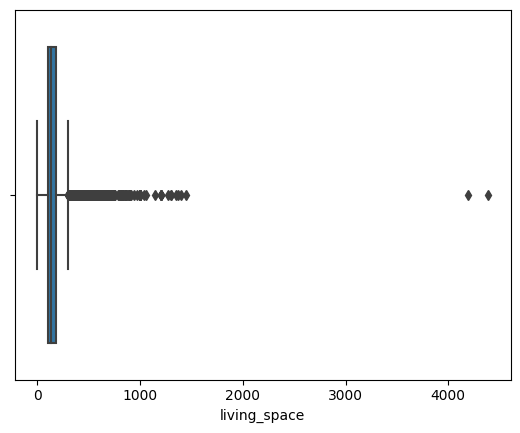

In [133]:
sns.boxplot(df.iloc[:, 0])

In [134]:
df.loc[df.iloc[:, 0].sort_values(ascending=False).head().index]

,living_space,rooms,plot_area,floor_space,floor,availability,price,municipality,street,street_nr,zip_code,canton,type
8403,4390.0,16.0,NaN,NaN,NaN,On request,NaN,Porza,NaN,NaN,6948,TI,villa
311,4193.0,NaN,NaN,NaN,NaN,On request,7500000.0,Villmergen,NaN,NaN,5612,AG,flat
8024,1450.0,18.0,6353.0,NaN,NaN,On request,NaN,Morcote,NaN,NaN,6922,TI,villa
10274,1400.0,21.0,31235.0,NaN,NaN,On request,NaN,Lausanne,NaN,NaN,1010,VD,detached-house
8862,1374.0,8.0,NaN,NaN,NaN,On request,3200000.0,Magliaso,NaN,NaN,6983,TI,flat


In [135]:
df.loc[df.iloc[:, 0].sort_values(ascending=True).head().index]

,living_space,rooms,plot_area,floor_space,floor,availability,price,municipality,street,street_nr,zip_code,canton,type
11585,1.0,NaN,176.0,NaN,NaN,On request,350000.0,Le Châble VS,NaN,NaN,1934,VS,detached-house
2733,5.0,5.5,1275.0,NaN,NaN,On request,750000.0,Combremont-le-Petit,NaN,NaN,1410,VD,villa
11823,12.0,NaN,NaN,NaN,0.0,Immediately,57000.0,Leukerbad,Zur Gasse,73,3954,VS,studio
11483,15.0,NaN,NaN,20.0,1.0,On request,93000.0,Ovronnaz,NaN,NaN,1911,VS,studio
8672,16.0,NaN,1200.0,NaN,NaN,Immediately,100000.0,Monteggio,NaN,NaN,6995,TI,detached-secondary-suite


/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='living_space'>

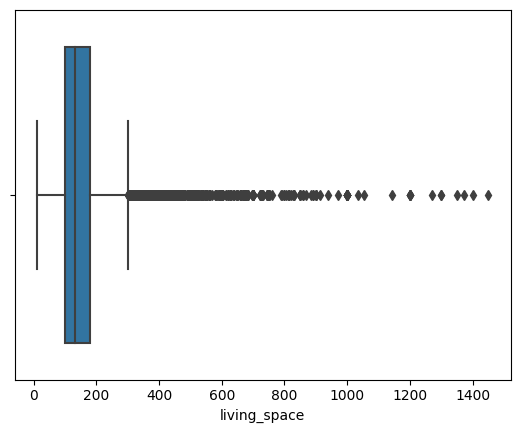

In [136]:
df.loc[(df['living_space'] > 1450) | (df['living_space'] < 12), 'living_space'] = np.nan
sns.boxplot(df.iloc[:, 0])

In [137]:
df.iloc[:, 0].describe()

count    12000.000000
mean       157.897000
std        108.545631
min         12.000000
25%        100.000000
50%        131.000000
75%        180.000000
max       1450.000000
Name: living_space, dtype: float64

# Rooms

In [138]:
df.iloc[:, 1].describe()

count    12487.000000
mean         5.159206
std          2.216823
min          1.500000
25%          3.500000
50%          4.500000
75%          5.500000
max         29.000000
Name: rooms, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rooms'>

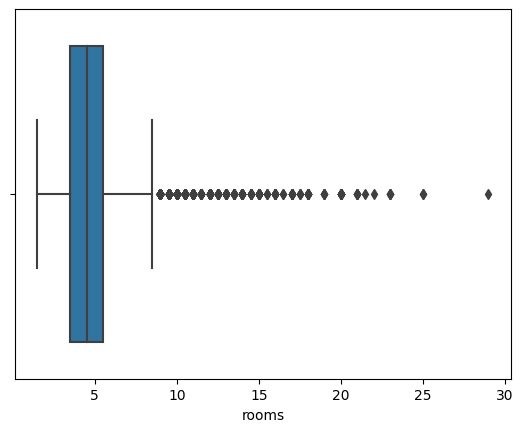

In [139]:
sns.boxplot(df.iloc[:, 1])

# Plot Area

In [140]:
df.iloc[:, 2].describe()

count      4838.000000
mean       1375.820794
std        7579.752701
min          20.000000
25%         341.000000
50%         610.500000
75%        1051.000000
max      350917.000000
Name: plot_area, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='plot_area'>

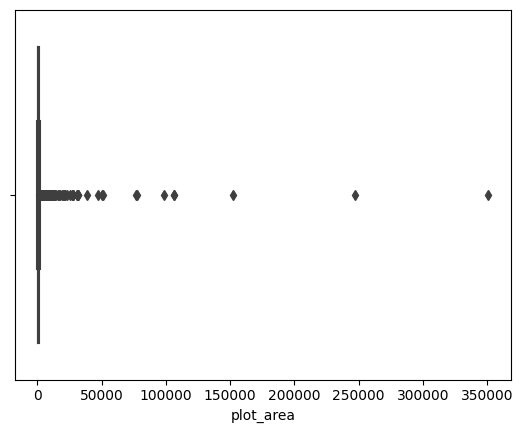

In [141]:
sns.boxplot(df.iloc[:, 2])

der grösste stimmt sicher mal nicht, die anderen vielleicht, darum entfernen wir diesen grössten

In [149]:
df.loc[df.iloc[:, 2].sort_values(ascending=False).head().index]

,living_space,rooms,plot_area,floor_space,floor,availability,price,municipality,street,street_nr,zip_code,canton,url,type
11699,165.0,5.5,350917.0,165.0,NaN,Immediately,1075000.0,Bellwald,NaN,NaN,3997,VS,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
5981,194.0,5.5,247330.0,220.0,NaN,Immediately,900000.0,Kienberg,Stücklermattweg,NaN,4468,SO,https://www.immoscout24.ch//en/d/semi-detached...,semi-detached-house
10495,1300.0,20.0,152000.0,2800.0,NaN,Immediately,NaN,Bourg-en-Lavaux,NaN,NaN,1096,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
10177,750.0,17.0,106494.0,NaN,NaN,On request,7000000.0,Orges,NaN,NaN,1422,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
10182,750.0,17.0,106494.0,NaN,NaN,On request,7000000.0,Orges,NaN,NaN,1422,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house


die kleinen scheinen zu stimmen

In [152]:
df.loc[df.iloc[:, 2].sort_values(ascending=True).head().index]

,living_space,rooms,plot_area,floor_space,floor,availability,price,municipality,street,street_nr,zip_code,canton,url,type
6858,92.0,4.0,20.0,108.0,NaN,Immediately,305000.0,Isone,NaN,NaN,6810,TI,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
6806,76.0,2.5,25.0,NaN,NaN,On request,240000.0,Winterthur,NaN,NaN,6584,TI,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
6821,100.0,4.5,27.0,NaN,NaN,On request,140000.0,Winterthur,Via di Funtànn,NaN,6584,TI,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
9406,90.0,3.5,30.0,NaN,NaN,On request,300000.0,Cevio,NaN,NaN,6692,TI,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
7825,138.0,7.5,32.0,NaN,NaN,On request,660000.0,Carona,NaN,NaN,6916,TI,https://www.immoscout24.ch//en/d/detached-hous...,detached-house


/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='plot_area'>

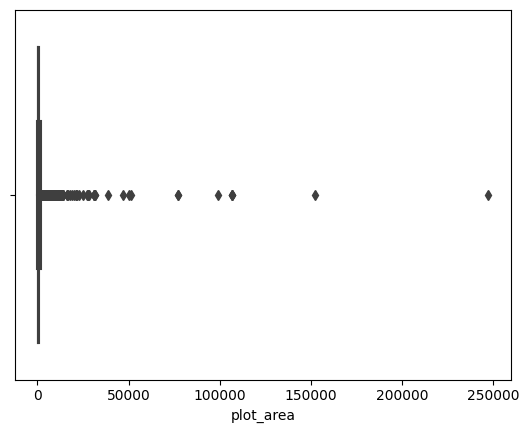

In [151]:
df.loc[(df['plot_area'] > 247330) , 'plot_area'] = np.nan
sns.boxplot(df.iloc[:, 2])

In [153]:
df.iloc[:, 2].describe()

count      4937.000000
mean       1319.286206
std        5814.045480
min          20.000000
25%         341.000000
50%         612.000000
75%        1054.000000
max      247330.000000
Name: plot_area, dtype: float64

# Floor Space

In [22]:
df.iloc[:, 3].describe()

count    2862.000000
mean      209.331237
std       272.702694
min         4.000000
25%       107.000000
50%       155.000000
75%       244.000000
max      7549.000000
Name: floor_space, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='floor_space'>

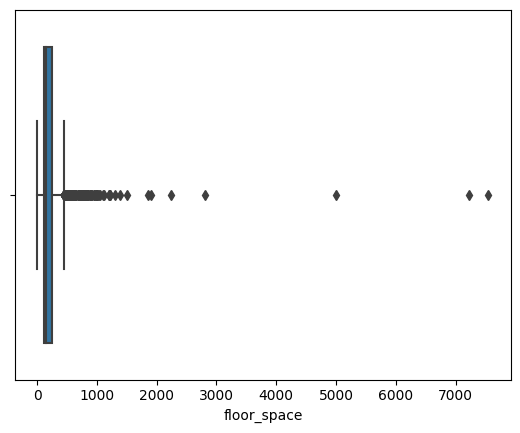

In [23]:
sns.boxplot(df.iloc[:, 3])

In [157]:
df.loc[df.iloc[:, 3].sort_values(ascending=False).head().index]

,living_space,rooms,plot_area,floor_space,floor,availability,price,municipality,street,street_nr,zip_code,canton,url,type
3310,420.0,17.0,7549.0,7549.0,NaN,On request,NaN,Ependes FR,Ependes FR,NaN,1731,FR,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
2719,NaN,NaN,21461.0,7223.0,NaN,On request,NaN,Waldenburg,NaN,NaN,4437,BL,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
7394,81.0,8.0,27000.0,5000.0,NaN,Immediately,230000.0,Mergoscia,Piatana,NaN,6632,TI,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
10495,1300.0,20.0,152000.0,2800.0,NaN,Immediately,NaN,Bourg-en-Lavaux,NaN,NaN,1096,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
11394,160.0,6.5,2233.0,2233.0,NaN,On request,1800000.0,Ried-Brig,Lieggjie,28,3911,VS,https://www.immoscout24.ch//en/d/detached-hous...,detached-house


In [159]:
df.loc[df.iloc[:, 3].sort_values(ascending=True).head().index]


,living_space,rooms,plot_area,floor_space,floor,availability,price,municipality,street,street_nr,zip_code,canton,url,type
2226,68.0,3.5,NaN,4.0,NaN,On request,560000.0,Unterseen,Beatenbergstrasse,31,3800,BE,https://www.immoscout24.ch//en/d/flat-buy-unte...,flat
13233,76.0,3.5,NaN,4.0,3.0,On request,730000.0,Horgen,Kalkofenstrasse,NaN,8810,ZH,https://www.immoscout24.ch//en/d/flat-buy-horg...,flat
4261,74.0,2.5,NaN,5.0,NaN,On request,695000.0,Laax GR,NaN,NaN,7031,GR,https://www.immoscout24.ch//en/d/flat-buy-laax...,flat
4063,92.0,4.5,NaN,6.0,1.0,On request,410000.0,Untervaz,NaN,NaN,7204,GR,https://www.immoscout24.ch//en/d/flat-buy-unte...,flat
406,98.0,3.5,NaN,6.0,NaN,On request,560000.0,Windisch,NaN,NaN,5212,AG,https://www.immoscout24.ch//en/d/attic-flat-bu...,attic-flat


# Floor

In [160]:
df.iloc[:, 4].describe()

count    5602.000000
mean        2.453767
std        29.856745
min        -4.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       999.000000
Name: floor, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='floor'>

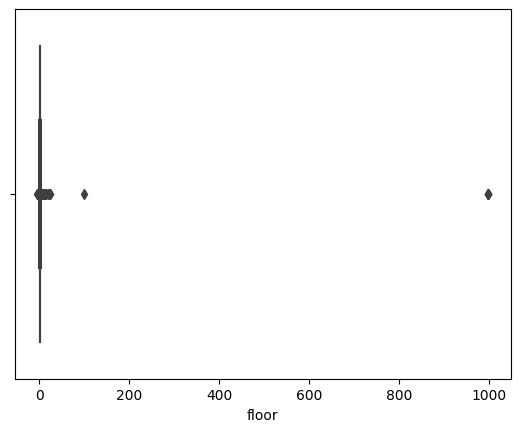

In [161]:
sns.boxplot(df.iloc[:, 4])

In [162]:
df.loc[df['floor'] >= 100.00, 'floor']

3156     100.0
10880    999.0
10907    999.0
11136    999.0
11331    999.0
11346    999.0
Name: floor, dtype: float64

In [163]:
df.loc[df['floor'] >= 100.00, 'floor'] = np.nan

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='floor'>

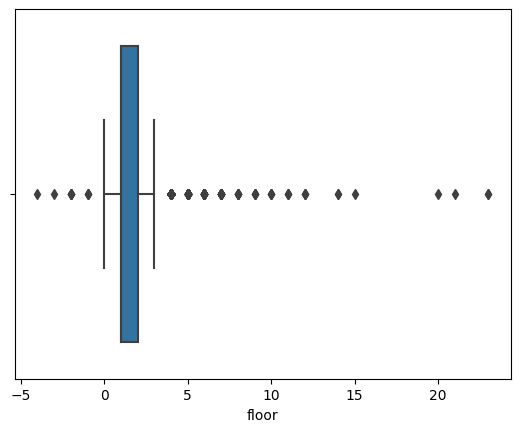

In [164]:
sns.boxplot(df.iloc[:, 4])

# Availability

In [29]:
df.iloc[:, 5].describe()

count          13057
unique           112
top       On request
freq            9395
Name: availability, dtype: object

In [32]:
df.iloc[:, 5].value_counts().to_frame().style.bar()

,availability
On request,9395
Immediately,2604
01.10.2022,81
01.11.2022,67
01.12.2023,54
01.04.2023,53
31.12.2023,43
01.12.2022,43
01.03.2023,38
01.02.2023,35


# Price

In [37]:
df.iloc[:, 6].describe()

count    1.205800e+04
mean     1.170870e+06
std      1.354530e+06
min      1.000000e+00
25%      5.850000e+05
50%      8.645000e+05
75%      1.319750e+06
max      4.500000e+07
Name: price, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

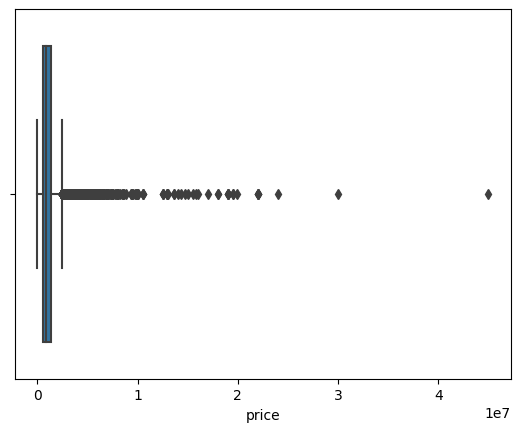

In [38]:
sns.boxplot(df.iloc[:, 6])

In [171]:
df.loc[df.iloc[:, 6].sort_values(ascending=True).head(20).index]

,living_space,rooms,plot_area,floor_space,floor,availability,price,municipality,street,street_nr,zip_code,canton,url,type
10713,NaN,NaN,NaN,NaN,NaN,On request,1.0,Etoy,NaN,NaN,1163,VD,https://www.immoscout24.ch//en/d/terrace-house...,terrace-house
3929,140.0,7.0,NaN,NaN,NaN,31.12.2022,2.0,Veyrier,NaN,NaN,1255,GE,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
5044,45.0,2.0,NaN,NaN,8.0,On request,745.0,Le Locle,NaN,NaN,2400,NE,https://www.immoscout24.ch//en/d/flat-buy-le-l...,flat
10553,19.0,NaN,NaN,NaN,NaN,15.09.2022,950.0,Ecublens VD,NaN,NaN,1026,VD,https://www.immoscout24.ch//en/d/single-room-b...,single-room
12762,66.0,2.5,NaN,NaN,NaN,Immediately,1020.0,Bramois,Route de Chippis,70,1967,VS,https://www.immoscout24.ch//en/d/flat-buy-bram...,flat
4421,75.0,3.5,NaN,NaN,NaN,On request,1100.0,Courtedoux,Faubourg,109,2905,JU,https://www.immoscout24.ch//en/d/flat-buy-cour...,flat
5049,110.0,5.5,NaN,NaN,2.0,On request,1275.0,Le Locle,NaN,NaN,2400,NE,https://www.immoscout24.ch//en/d/flat-buy-le-l...,flat
3637,NaN,NaN,NaN,NaN,NaN,On request,1600.0,Grand-Lancy,Chemin des semailles,9c,1212,GE,https://www.immoscout24.ch//en/d/flat-buy-gran...,flat
11381,NaN,NaN,NaN,NaN,NaN,On request,1850.0,Chernex,NaN,NaN,1822,VD,https://www.immoscout24.ch//en/d/flat-buy-cher...,flat
10821,NaN,3.0,NaN,NaN,NaN,On request,1850.0,Mont-sur-Rolle,NaN,NaN,1180,VD,https://www.immoscout24.ch//en/d/flat-buy-roll...,flat


In [174]:
df.loc[df.iloc[:, 6].sort_values(ascending=False).head(20).index]

,living_space,rooms,plot_area,floor_space,floor,availability,price,municipality,street,street_nr,zip_code,canton,url,type
10680,NaN,10.0,5000.0,NaN,NaN,On request,45000000.0,Etoy,NaN,NaN,1162,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
11028,1200.0,14.0,8071.0,NaN,NaN,On request,30000000.0,Versoix,NaN,NaN,1295,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
10217,700.0,14.5,5039.0,900.0,NaN,On request,24000000.0,Lausanne,NaN,NaN,1006,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
11012,804.0,15.0,8071.0,NaN,NaN,Immediately,22000000.0,Versoix,NaN,NaN,1295,VD,https://www.immoscout24.ch//en/d/villa-buy-tan...,villa
11034,745.0,16.0,5000.0,NaN,NaN,On request,22000000.0,Versoix,NaN,NaN,1295,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
11046,600.0,12.0,5000.0,NaN,NaN,On request,22000000.0,Versoix,NaN,NaN,1295,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
11069,NaN,8.0,5000.0,780.0,NaN,Immediately,22000000.0,Versoix,NaN,NaN,1295,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
11316,560.0,9.5,3301.0,NaN,NaN,On request,19950000.0,Clarens,NaN,NaN,1815,VD,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
3797,1000.0,14.0,2959.0,NaN,NaN,On request,19500000.0,Corsier GE,NaN,NaN,1245,GE,https://www.immoscout24.ch//en/d/detached-hous...,detached-house
3826,594.0,14.0,2959.0,NaN,NaN,Immediately,19500000.0,Corsier GE,NaN,NaN,1245,GE,https://www.immoscout24.ch//en/d/detached-hous...,detached-house


/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

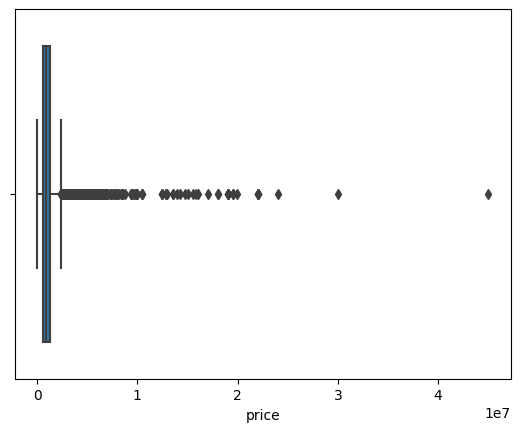

In [172]:
df.loc[(df['price'] < 30000), 'price'] = np.nan
sns.boxplot(df.iloc[:, 6])

In [173]:
df.iloc[:, 6].describe()

count    1.231200e+04
mean     1.171130e+06
std      1.346531e+06
min      3.000000e+04
25%      5.850000e+05
50%      8.650000e+05
75%      1.318250e+06
max      4.500000e+07
Name: price, dtype: float64

# Municipality

In [40]:
df.iloc[:, 7].describe()

count        13057
unique        1295
top       Lausanne
freq           132
Name: municipality, dtype: object

# Strasse

In [41]:
df.iloc[:, 8].describe()

count             5843
unique            3511
top       Hauptstrasse
freq                93
Name: street, dtype: object

# Strassennummer

In [42]:
df.iloc[:, 9].describe()

count     2698
unique     451
top         10
freq       116
Name: street_nr, dtype: object

# Postleitzahl

In [43]:
df.iloc[:, 10].describe()

count     13069
unique     1943
top        5462
freq         24
Name: zip_code, dtype: object

# Kanton

In [44]:
df.iloc[:, 11].describe()

count     13069
unique       26
top          TI
freq       2676
Name: canton, dtype: object

# Typ

In [46]:
df.iloc[:, 12].value_counts().to_frame().style.bar()

,type
flat,5850
detached-house,3483
villa,702
semi-detached-house,571
penthouse,540
terrace-house,511
duplex-maisonette,425
chalet,281
attic-flat,239
stepped-apartment,139


Rest siehe viz html